### システム概要 - 仕様書

#### 1. **課題**
- **目標**: FXのトレードを毎日繰り返し、最終日の日本円での資産の最大化。
- **評価**: 以下のシナリオのうち、Jun_Aug_2017_without_commission、Jun_Aug_2017_with_commissionに提出いただいた最初の5回の平均と最大。

#### 2. **条件**
- **初期資産**: 1,000,000円
- **トレード頻度**: 平日に一日一度、FXレートを基に貨幣の取引が可能。
- **手数料**: 取引額のX％
- **取引可能な通貨**: JPY, USD, EUR, AUD, HKD
- **評価方法**: 最終日に全資産をJPYに変換し、その価値を評価。

#### 3. **問題セット**
各問題セットでは、以下の情報が提供されます：
- **シナリオ名**: Scenario name
- **取引開始日**: Start Date
- **取引終了日**: End Date
- **手数料**: 手数料率

例:
- TEST0: 2016-01-04 ～ 2016-01-11, 手数料 0%
- TEST1: 2016-01-04 ～ 2016-01-11, 手数料 0.1%
- Jun_Aug_2016_without_commission: 2016-06-01 ～ 2016-08-31, 手数料 0%
- Jun_Aug_2016_with_commission: 2016-06-01 ～ 2016-08-31, 手数料 0.1%
- Feb_Apr_2017_without_commission: 2017-02-01 ～ 2017-04-28, 手数料 0%
- Feb_Apr_2017_wit_commission: 2017-02-01 ～ 2017-04-28, 手数料 0.1%
- Jun_Aug_2017_without_commission: 2017-06-01 ～ 2017-08-31, 手数料 0%
- Jun_Aug_2017_with_commission: 2017-06-01 ～ 2017-08-31, 手数料 0.1%

Jun_Aug_2017_without_commissionとJun_Aug_2017_with_commissionにつきましては、評価で使用するために、当日皆様にお配りするuserIdを用いないとセッションを開始することはできません。

#### 4. **API 概要**
システムは以下のAPIを使用してトレードセッションを管理します。

1. **セッション開始**:
   - **概要**: 指定されたシナリオとUserIdに基づいて、トレードセッションを開始します。
   - **エンドポイント**: `POST /api/trade/start/<scenario>/<userId>`
   - **userId**: userIdは皆さんにご入場の際にお配りした6文字をお使いください。
   - **currentDate**: 現在の日付
   - **jpyBalance**: 現在の日本円での資産。
   - **currentcyToBalance**: 現在のそれぞれの貨幣の資産の量
   - **currentDateRate**: 現在の日付の為替レート
   - **complete**: セッションが終了しているかどうかを表すフラグ
   - **レスポンス例**:
     ```json
     {
       "sessionId": 0,
       "startDate": "2016-01-04",
       "endDate": "2016-01-11",
       "currentDate": "2016-01-04",
       "jpyBalance": 1000000,
       "currencyToBalance": {
         "JPY": 1000000
       },
       "currentDateRates": {
         "USD/JPY": 120.4,
         "EUR/JPY": 130.59
       },
       "complete": false
     }
     ```

2. **取引の実行**:
   - **概要**: セッションの現在日付において、指定された取引を実行します。取引は最終日まで繰り返されます。指定した量の貨幣をcurrencyFromからcurrencyToへ、為替レートcurrentDateRatesを使って変換します。
   
   - **エンドポイント**: `POST /api/trade/next`
   - **リクエスト例**:
     ```json
     {
       "sessionId": 0,
       "exchangeRequests": [
         {
           "currencyFrom": "JPY",
           "currencyTo": "USD",
           "amount": 1000
         },
         {
           "currencyFrom": "JPY",
           "currencyTo": "AUD",
           "amount": 1000
         }
       ]
     }
     ```
   - **レスポンス例**:
   - レスポンスは`POST /api/trade/start/<scenario>/<userId>`と同様だが、currencyToBalanceが先ほどのリクエストに基づいて変更され、currentDateは翌日に、currentDateRatesが翌日の為替レートに、jpyBalanceが翌日の為替レートと現在の保有資産に基づいてアップデートされている。
     ```json
     {
       "sessionId": 0,
       "startDate": "2016-01-04",
       "endDate": "2016-01-11",
       "currentDate": "2016-01-05",
       "jpyBalance": 999969.0392754745,
       "currencyToBalance": {
         "JPY": 998000,
         "USD": 8.30564784053156,
         "AUD": 11.415525114155253
       },
       "currentDateRates": {
         "USD/JPY": 119.27,
         "EUR/JPY": 129.17
       },
       "complete": false
     }
     ```
    - これをcurrentDate == endDate になるまで繰り返す。その際、complete == trueとなっている。

3. **FxRateの参照**:
   - **エンドポイント**:
     - `GET /api/rate/{date}`: 
   - **レスポンス例**:
     ```json
     {
         "USD/JPY": 120.4,
         "EUR/JPY": 130.59
     }
     ```

In [54]:
# import library
%matplotlib inline
import requests
import copy
import matplotlib.pyplot as plt
import numpy as np
import time
from datetime import datetime, timedelta
from matplotlib import ticker

In [47]:
# Define common variables
CURRENCY_LIST = ['JPY','USD','AUD','HKD','EUR']
JPY_PAIR_LIST =[currency + '/JPY'  for currency in CURRENCY_LIST if currency != 'JPY']
CURRENCY_PAIR = [f"{currency1}/{currency2}" for currency1 in CURRENCY_LIST for currency2 in CURRENCY_LIST if currency1 != currency2]
TESTCASE = 'TEST0'
USERID = 'testuser'
BASE_URL = 'http://os3-389-27987.vs.sakura.ne.jp/'
START_URL = BASE_URL + 'api/trade/start/{}/{}'
NEXT_URL = BASE_URL + 'api/trade/next'
RATE_URL = BASE_URL + 'api/rate/{}'

In [52]:
# Define common functions
def get_last_n_weekdays(date_str, n):
    given_date = datetime.strptime(date_str, '%Y-%m-%d').date()
    weekdays = []
    
    current_date = given_date
    while len(weekdays) < n:
        if current_date.weekday() < 5:  # Monday is 0 and Friday is 4
            weekdays.append(current_date.strftime('%Y-%m-%d'))
        current_date -= timedelta(days=1)
    
    return weekdays[::-1]

def init_rates_last_n_weekdays(date_str, n):
    dates = get_last_n_weekdays(date_str, n)
    currency_pair_to_rates = {currency_pair: [] for currency_pair in CURRENCY_PAIR}
    for date in dates:
        response = requests.get(RATE_URL.format(date))
        currency_pair_to_rate = response.json()
        for currency_pair, rate in currency_pair_to_rate.items(): currency_pair_to_rates[currency_pair].append(rate)
    return currency_pair_to_rates

def update_rates(currency_pair_to_rates, next_date_rates):
    for currency_pair, rate in next_date_rates.items(): currency_pair_to_rates[currency_pair].append(rate)

def get_currency_pairs(currency_from):
    return [currency + '/' + currency_from for currency in CURRENCY_LIST if currency != currency_from]

def plot_chart(axes, rates, today=None, label=None):
    axes.xaxis.set_major_locator(ticker.MultipleLocator(10))
    if today:
        x = get_last_n_weekdays(today, len(rates))
    else:
        x = range(len(rates))
    axes.plot(x, rates, label=label)

def get_dma(rates, x):
    return [sum(rates[max(0, i-x):i+1]) / len(rates[max(0, i-x):i+1]) for i in range(len(rates))]

In [49]:
# Example with changing fixed JPY amount to USD, AUD
def fixed_amount_from_jpy_to_usd(amount):
    return [{
            'currencyFrom': 'JPY',
            'currencyTo': 'USD',
            'amount': amount
        }, {
            'currencyFrom': 'JPY',
            'currencyTo': 'AUD',
            'amount': amount
        }]

In [5]:
TESTCASE = 'TEST0'

response = requests.post(START_URL.format(TESTCASE, USERID))
session_info = response.json()
session_id = session_info['sessionId']
is_complete = session_info['complete']
start_date = session_info['startDate']
current_date = session_info['currentDate']
currency_to_balance = session_info['currencyToBalance']
currency_pair_to_rates = init_rates_last_n_weekdays(start_date, 10)

while not is_complete: 
    exchange_requests = fixed_amount_from_jpy_to_usd(1000)
    request_body_next = {
        'sessionId': session_id,
        'exchangeRequests': exchange_requests
    }
    if len(exchange_requests) > 0: print('current date: ' + current_date + ', exchange_requests' + str(exchange_requests))
    response = requests.post(NEXT_URL, json=request_body_next)
    next_info = response.json()
    update_rates(currency_pair_to_rates, next_info['currentDateRates'])
    current_date = next_info['currentDate']
    currency_to_balance = next_info['currencyToBalance']
    is_complete = next_info['complete']

result = next_info['jpyBalance']
print(result)

current date: 2016-01-04, exchange_requests[{'currencyFrom': 'JPY', 'currencyTo': 'USD', 'amount': 1000}, {'currencyFrom': 'JPY', 'currencyTo': 'AUD', 'amount': 1000}]
current date: 2016-01-05, exchange_requests[{'currencyFrom': 'JPY', 'currencyTo': 'USD', 'amount': 1000}, {'currencyFrom': 'JPY', 'currencyTo': 'AUD', 'amount': 1000}]
current date: 2016-01-06, exchange_requests[{'currencyFrom': 'JPY', 'currencyTo': 'USD', 'amount': 1000}, {'currencyFrom': 'JPY', 'currencyTo': 'AUD', 'amount': 1000}]
current date: 2016-01-07, exchange_requests[{'currencyFrom': 'JPY', 'currencyTo': 'USD', 'amount': 1000}, {'currencyFrom': 'JPY', 'currencyTo': 'AUD', 'amount': 1000}]
current date: 2016-01-08, exchange_requests[{'currencyFrom': 'JPY', 'currencyTo': 'USD', 'amount': 1000}, {'currencyFrom': 'JPY', 'currencyTo': 'AUD', 'amount': 1000}]
999814.7663383546


In [39]:
# 逆張り戦略の例
# 所持している資産の通貨が{x}日間連続で別の通貨に対して上昇しているとき、その通貨に{y}%変更する
# 例えば、USD/JPYが3日間連続で減少しているとき、[130, 129, 128]、円はドルに対して価値が上昇しているので、円をドルに変更する
CURRENCY_LIST = ['JPY','USD','AUD','HKD','EUR']

def contranian_strategy(currency_pair_to_rates, currency_to_balance, x, y):
    exchange_requests = []
    for currency, balance in currency_to_balance.items():
        if balance > 0:
            currency_pairs = get_currency_pairs(currency)
            for currency_pair in currency_pairs:
                rates = currency_pair_to_rates[currency_pair][-x:]
                if all(rates[i] > rates[i + 1] for i in range(len(rates) - 1)):
                    print(currency_pair + ' rates for past x days: ' + str(rates))
                    currency_pair_to_exchange = currency_pair
                    exchange_requests.append({
                        'currencyFrom': currency,
                        'currencyTo': currency_pair[:3],
                        'amount': balance * y / 100.0
                    })
                    break
    return exchange_requests

In [98]:
TESTCASE = 'Jun_Aug_2016_without_commission'

response = requests.post(START_URL.format(TESTCASE, USERID))
session_info = response.json()
session_id = session_info['sessionId']
is_complete = session_info['complete']
start_date = session_info['startDate']
current_date = session_info['currentDate']
currency_to_balance = session_info['currencyToBalance']
currency_pair_to_rates = init_rates_last_n_weekdays(start_date, 10)

while not is_complete: 
    exchange_requests = contranian_strategy(currency_pair_to_rates, currency_to_balance, 5, 30)
    request_body_next = {
        'sessionId': session_id,
        'exchangeRequests': exchange_requests
    }
    if len(exchange_requests) > 0: print('current date: ' + current_date + ', exchange_requests' + str(exchange_requests))
    response = requests.post(NEXT_URL, json=request_body_next)
    next_info = response.json()
    update_rates(currency_pair_to_rates, next_info['currentDateRates'])
    current_date = next_info['currentDate']
    currency_to_balance = next_info['currencyToBalance']
    is_complete = next_info['complete']

result = next_info['jpyBalance']
print(result)

USD/JPY rates for past x days: [110.94, 110.62, 109.38, 108.87, 106.61]
current date: 2016-06-06, exchange_requests[{'currencyFrom': 'JPY', 'currencyTo': 'USD', 'amount': 300000.0}]
AUD/JPY rates for past x days: [79.95, 79.4, 78.47, 78.45, 77.9]
current date: 2016-06-15, exchange_requests[{'currencyFrom': 'JPY', 'currencyTo': 'AUD', 'amount': 210000.0}]
USD/JPY rates for past x days: [106.12, 105.65, 104.73, 104.72, 103.83]
current date: 2016-06-21, exchange_requests[{'currencyFrom': 'JPY', 'currencyTo': 'USD', 'amount': 147000.0}]
EUR/AUD rates for past x days: [1.525080179602309, 1.5163036473772393, 1.5094993581514762, 1.5062166962699823, 1.490653040877368]
current date: 2016-06-24, exchange_requests[{'currencyFrom': 'AUD', 'currencyTo': 'EUR', 'amount': 808.7291399229781}]
EUR/AUD rates for past x days: [1.5163036473772393, 1.5094993581514762, 1.5062166962699823, 1.490653040877368, 1.4854919546293854]
current date: 2016-06-27, exchange_requests[{'currencyFrom': 'AUD', 'currencyTo':

In [93]:
# ゴールデンクロス・デッドクロスの例
# 全資産をJPYを除く各通貨に均等に割り当て、x日移動平均がy日移動平均を上回る場合は上昇トレンド、下回る場合は下降トレンドと判断し、その通貨に変更する
def golden_and_death_cross_strategy(currency_pair_to_rates, currency_to_balance, x, y):
    exchange_requests = []
    trend = {}
    # ポジションを持っていない通貨を計算
    currencies_without_position = [currency for currency, balance in currency_to_balance.items() if balance == 0]

    # それぞれの通貨についてトレンドを計算
    for currency, balance in currency_to_balance.items():
        if currency != 'USD':
            continue
        currency_pair = currency + '/JPY'
        if sum(currency_pair_to_rates[currency_pair][-x:])/x > sum(currency_pair_to_rates[currency_pair][-y:])/y:
            # 上昇トレンドと判断
            if balance == 0:
                # (保有する円/ポジションを持っていない通貨の数)を変更
                exchange_requests.append({
                        'currencyFrom': 'JPY',
                        'currencyTo': currency,
                        'amount': currency_to_balance['JPY'] / len(currencies_without_position)
                    })
        else:
            # 下降トレンドと判断
            if  balance > 0:
                # ポジションを解消
                exchange_requests.append({
                        'currencyFrom': currency,
                        'currencyTo': 'JPY',
                        'amount': currency_to_balance[currency]
                    })
    return exchange_requests

In [99]:
TESTCASE = 'Jun_Aug_2016_without_commission'
X = 5
Y = 10

response = requests.post(START_URL.format(TESTCASE, USERID))
session_info = response.json()
session_id = session_info['sessionId']
is_complete = session_info['complete']
start_date = session_info['startDate']
current_date = session_info['currentDate']
currency_to_balance = session_info['currencyToBalance']
currency_pair_to_rates = init_rates_last_n_weekdays(start_date, 10)

while not is_complete:
    exchange_requests = golden_and_death_cross_strategy(currency_pair_to_rates, currency_to_balance, X, Y)
    request_body_next = {
        'sessionId': session_id,
        'exchangeRequests': exchange_requests
    }
    if len(exchange_requests) > 0: print('current date: ' + current_date + ', exchange_requests' + str(exchange_requests))
    response = requests.post(NEXT_URL, json=request_body_next)
    next_info = response.json()
    update_rates(currency_pair_to_rates, next_info['currentDateRates'])
    current_date = next_info['currentDate']
    currency_to_balance = next_info['currencyToBalance']
    is_complete = next_info['complete']

result = next_info['jpyBalance']
print(current_date, result)

current date: 2016-06-01, exchange_requests[{'currencyFrom': 'JPY', 'currencyTo': 'USD', 'amount': 250000.0}]
current date: 2016-06-06, exchange_requests[{'currencyFrom': 'USD', 'currencyTo': 'JPY', 'amount': 2259.98915205207}]
current date: 2016-07-14, exchange_requests[{'currencyFrom': 'JPY', 'currencyTo': 'USD', 'amount': 247734.3608750678}]
current date: 2016-07-28, exchange_requests[{'currencyFrom': 'USD', 'currencyTo': 'JPY', 'amount': 2379.5443365197175}]
current date: 2016-08-12, exchange_requests[{'currencyFrom': 'JPY', 'currencyTo': 'USD', 'amount': 248079.39480386316}]
current date: 2016-08-17, exchange_requests[{'currencyFrom': 'USD', 'currencyTo': 'JPY', 'amount': 2427.1538479978785}]
current date: 2016-08-29, exchange_requests[{'currencyFrom': 'JPY', 'currencyTo': 'USD', 'amount': 247157.07634162396}]
2016-08-31 991683.5189070674


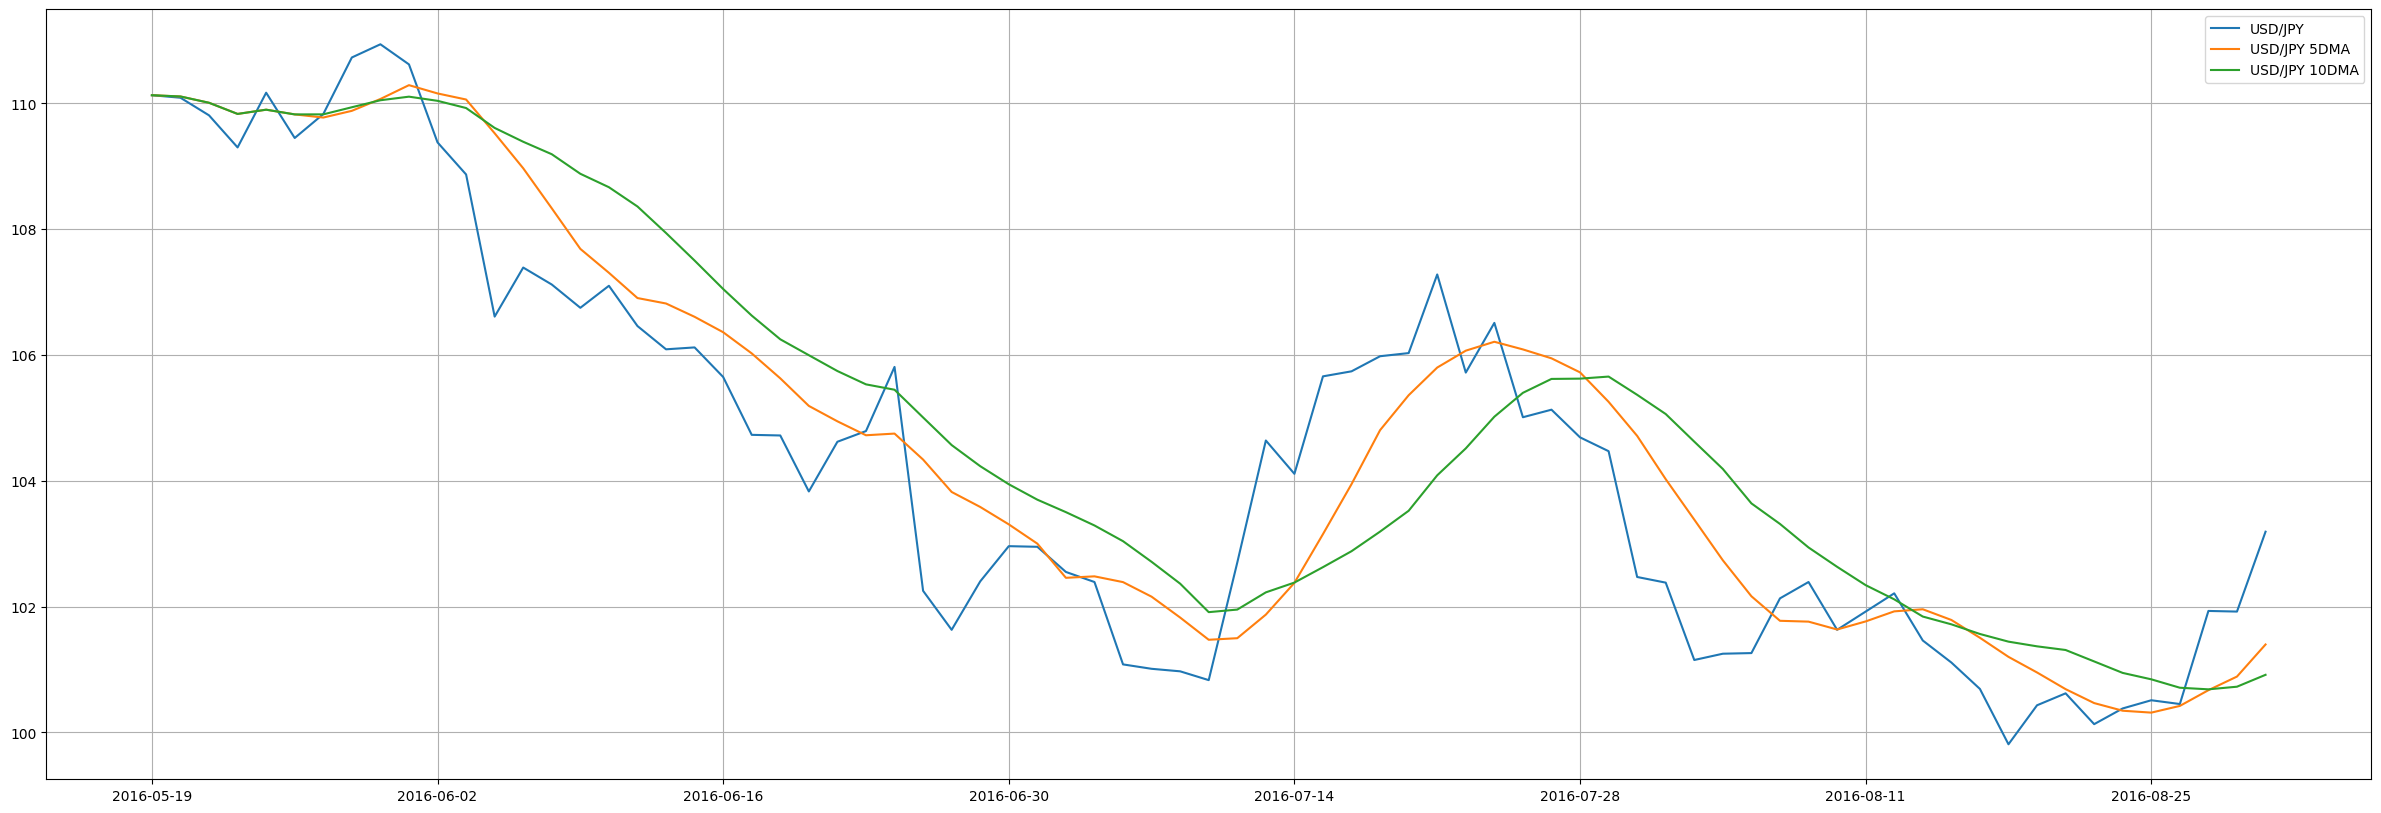

In [87]:
figure, ax = plt.subplots(figsize=(30,10))
ax.grid()
currency_pair = 'USD/JPY'
plot_chart(ax, currency_pair_to_rates[currency_pair], today=current_date, label=currency_pair)
plot_chart(ax, get_dma(currency_pair_to_rates[currency_pair], X), today=current_date, label=currency_pair + ' {}DMA'.format(X))
plot_chart(ax, get_dma(currency_pair_to_rates[currency_pair], Y), today=current_date, label=currency_pair + ' {}DMA'.format(Y))
plt.legend()
plt.show()